# Analyze Ball on Incline data
Use this notebook to quickly test whether your ball on incline data makes sense!

In [12]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit, cost

from BallOnIncline_data import *

In [13]:
filenames

['Big_1.csvBig_1b.csvBig_2.csvBig_2b.csvBig_3.csvBig_3b.csvBig_4.csvBig_4b.csvLittle_1.csvLittle_1b.csvLittle_2.csvLittle_2b.csvLittle_3.csvLittle_3b.csvLittle_4.csvLittle_4b.csvMedium_1.csvMedium_1b.csvMedium_2.csvMedium_2b.csvMedium_3.csvMedium_3b.csvMedium_4.csvMedium_4b.csv']

In [5]:
Blinding = True
#adding a unit gaussian:
Blinding_value = np.random.normal(0,1) if Blinding else 0.0

## Reading the data

The function "read_csv(filename)" takes in a filename and returns numpy arrays with time and voltage.

In [3]:
def read_csv(filename):
    """Read CSV from Waveforms"""
    dat = np.genfromtxt(filename, delimiter=',', skip_header=13, names=True)
    time = dat['Time_s']
    voltage = dat['Channel_1_V']
    return time, voltage

def find_midpoints(time, voltage, show_plot=True):
    # finding all the places where the ball passes above a certain voltage threshold
    voltage_threshold = 1
    # getting the times at which the ball initially crosses the threshold ie the previous voltage is below the threshold and the current voltage is above
    passes = np.where((voltage[:-1] < voltage_threshold) & (voltage[1:] >= voltage_threshold))

    t_pass = time[passes]
    #we can estimate the uncertainty as the time difference between two measurements
    t_pass_sigma = np.full_like(t_pass, np.mean(np.diff(time)))
    
    return t_pass, t_pass_sigma

Text(0, 0.5, 'Voltage (V)')

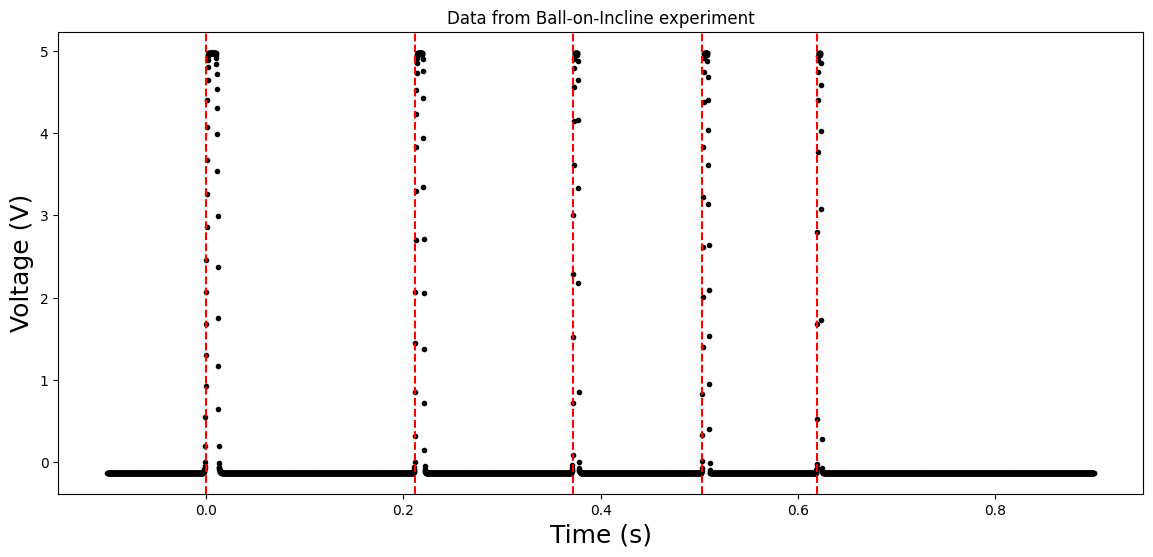

In [4]:
# Read the data and plot it (possibly with passing times in):
filename = 'data_BallOnIncline_example/ball7_8mm_example.csv'

time, voltage = read_csv(filename)
timepass, timepass_sig = find_midpoints(time, voltage)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(time, voltage, 'k.', label='Measurements')
#adding a vertical line at each time the ball passes
for t in timepass:
    ax.axvline(t, color='r', linestyle='--', label='Ball pass' if t == timepass[0] else "")
ax.set_title("Data from Ball-on-Incline experiment")
ax.set_xlabel("Time (s)", fontsize=18)
ax.set_ylabel("Voltage (V)", fontsize=18)

# What to do next?

From the V(t) data you should be able to determine five times at which the ball passed. Discuss in the group how to do this best, and possibly test it by seeing if the result is "invariant" between different data sets.

Note that getting an uncertainty can be hard, and think about the relevance of such an uncertainty, which should anyway be rather small.

Text(0, 0.5, 'Distance (m)')

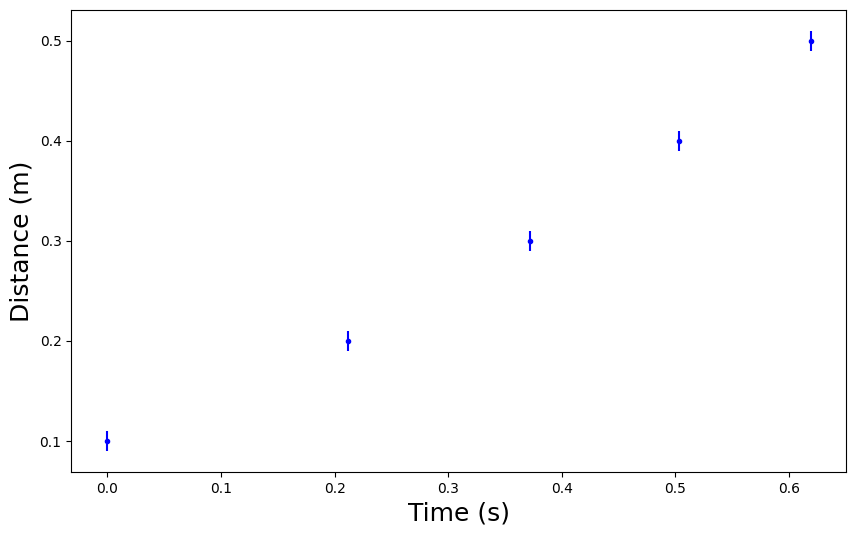

In [17]:
Distances = np.array([0.1, 0.2, 0.3, 0.4, 0.5])  # distances in meters
Distances_sig = np.array([0.01, 0.01, 0.01, 0.01, 0.01])  # uncertainties in meters
# Passing times
Times = timepass  # times in seconds
Time_sig = timepass_sig  # uncertainties in seconds

#plotting the x-t graph
fig2, ax2 = plt.subplots(figsize=(10,6))
ax2.errorbar(Times, Distances, xerr=Time_sig, yerr=Distances_sig, fmt='.', color='b')
ax2.set_xlabel('Time (s)', fontsize=18)
ax2.set_ylabel('Distance (m)', fontsize=18)

In [25]:
#fitting a parabolic function using chi squared minimization
def parabolic(x, a, b, c):
    return 1/2 * a*x**2 + b*x + c
chi2_object_function = cost.LeastSquares(timepass, Distances, timepass_sig, parabolic)
m = Minuit(chi2_object_function, a=1.0, b=1.0, c=0.0)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7.88 (χ²/ndof = 3.9)       │              Nfcn = 66               │
│ EDM = 4.1e-16 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.865   │   0.004   │            │            │         │         │       │
│ 1 │ b    │  0.3779   │  0.0014   │            │            │         │         │       │
│ 2 │ c    │ 100.29e-3 │  0.19e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────┐
│   │        a        b        c │
├───┼────────────────────────────┤
│ a │ 1.96e-05  -6.0e-6  0.45e-6 │
│ b │  -6.0e-6 2.02e-06 -0.19e-6 │
│ c │  0.45e-6 -0.19e-6 3.77e-08 │
└───┴────────────────────────────┘

In [27]:
acceleration = m.values['a']
acceleration_sig = m.errors['a']

In [34]:
#To get g we need to correct for the incline angle
incline_angle_deg = 12  # degrees
theta = np.radians(incline_angle_deg)
delta_theta = 0
radius_ball = 0.008  # meters
D_ball = 2 * radius_ball
d_rail = 0.01  # meters
# Calculating g from the acceleration down the incline
g = acceleration / np.sin(theta+delta_theta) * (1 - (2/5) * (D_ball**2) / (D_ball**2 - (d_rail)**2))
# Propagating the uncertainty
g_sig = 0 #to be calculated
print(f'Calculated g: {g:.4f} ± {g_sig:.4f} m/s^2')

Calculated g: 1.4289 +/- 0.0000 m/s^2
